**Предсказание вероятности совершения покупки в течение 90 дней**

**Описание проекта:**

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель проекта:**

Предсказать вероятность покупки в течение 90 дней

**Описание данных:**

Датасет состоит из пяти файлов:

apparel-purchases.csv - данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук
apparel-messages.csv - рассылки, которые были отправлены клиентам из таблицы покупок
full_campaign_daily_event.csv - агрегация общей базы рассылок по дням и типам событий
full_campaign_daily_event_channel.csv - агрегация по дням с учетом событий и каналов рассылки
apparel-target_binary - целевой признак. Для каждого идентификатора клиента необходимо предсказать категориальное значение соответствующее прогнозу [0, 1].

**План работы**

Загрузка и ознакомление с данными  
Полноценный разведочный анализ  
Разработка новых синтетических признаков  
Проверка на мультиколлинеарность  
Выбор и обучение моделей  
Анализ важности признаков лучшей модели  
Общий вывод

In [234]:
import pandas as pd
import numpy as np
import ast
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
f1_score, precision_score, recall_score, 
roc_auc_score, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
)
import datetime
from datetime import timedelta
import shap
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings('ignore')
!pip freeze > requirements.txt

Создадим необходимые для дальнейшего обучения моделей константы:

In [235]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

**1. Загрузка и предварительная обработка данных**

In [236]:
df_purchases = pd.read_csv(
    '/kaggle/input/marketing/apparel-purchases.csv', parse_dates=['date']
)

In [237]:
df_messages = pd.read_csv(
    '/kaggle/input/marketing/apparel-messages.csv', parse_dates=['date', 'created_at']
)

In [238]:
df_target = pd.read_csv(
    '/kaggle/input/marketing/apparel-target_binary.csv'
)

In [239]:
df_daily_event = pd.read_csv(
    '/kaggle/input/marketing/full_campaign_daily_event (1).csv'
)

In [240]:
df_daily_event_channel = pd.read_csv(
    '/kaggle/input/marketing/full_campaign_daily_event_channel.csv'
)

In [241]:
df_purchases.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [242]:
df_messages.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [243]:
df_target.head(10)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


In [244]:
df_daily_event.head(10)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,0,8,0,0,0,0,...,6,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [245]:
df_daily_event_channel.head(10)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Выведем общую информацию о загруженных датасетах:

In [246]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [247]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [248]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [249]:
df_daily_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

In [250]:
df_daily_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

Выведем основные статистические характеристики

In [251]:
df_purchases.describe().T

,count,mean,min,25%,50%,75%,max,std
client_id,202208.0,1515915625596210944.0,1515915625468060928.0,1515915625490081280.0,1515915625557177088.0,1515915625624391936.0,1515915626010443520.0,145945755.930884
quantity,202208.0,1.006483,1.0,1.0,1.0,1.0,30.0,0.184384
price,202208.0,1193.301516,1.0,352.0,987.0,1699.0,85499.0,1342.252664
date,202208,2023-03-17 02:49:35.739832064,2022-05-16 00:00:00,2022-11-12 00:00:00,2023-04-12 00:00:00,2023-07-03 00:00:00,2024-02-16 00:00:00,NaN


In [252]:
df_messages.describe().T

,count,mean,min,25%,50%,75%,max,std
bulk_campaign_id,12739798.0,11604.587587,548.0,8746.0,13516.0,14158.0,14657.0,3259.211131
client_id,12739798.0,1515915625574831616.0,1515915625468060928.0,1515915625489149440.0,1515915625503432192.0,1515915625591286272.0,1515915626010288640.0,132970411.558955
date,12739798,2023-06-05 02:46:08.357990400,2022-05-19 00:00:00,2022-12-19 00:00:00,2023-07-20 00:00:00,2023-11-21 00:00:00,2024-02-15 00:00:00,NaN
created_at,12739798,2023-06-05 13:58:11.168689408,2022-05-19 00:14:20,2022-12-19 12:46:30,2023-07-20 17:21:54,2023-11-21 18:13:05,2024-02-15 23:58:40,NaN


In [253]:
df_target.describe().T

,count,mean,std,min,25%,50%,75%,max
client_id,49849.0,1.515916e+18,1.487947e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
target,49849.0,1.927822e-02,1.375025e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [254]:
df_daily_event.describe().T

,count,mean,std,min,25%,50%,75%,max
bulk_campaign_id,131072.0,8416.743378,4877.369306,548.0,4116.0,7477.0,13732.0,15150.0
count_click,131072.0,90.982971,1275.503564,0.0,0.0,0.0,2.0,128453.0
count_complain,131072.0,0.932655,30.198326,0.0,0.0,0.0,0.0,5160.0
count_hard_bounce,131072.0,78.473434,1961.317826,0.0,0.0,0.0,0.0,287404.0
count_open,131072.0,3771.090691,65160.668444,0.0,1.0,6.0,30.0,5076151.0
count_purchase,131072.0,0.577927,9.107040,0.0,0.0,0.0,0.0,1077.0
count_send,131072.0,11634.142319,175709.508290,0.0,0.0,0.0,0.0,11543513.0
count_soft_bounce,131072.0,27.807312,736.944714,0.0,0.0,0.0,0.0,76284.0
count_subscribe,131072.0,0.140518,2.072777,0.0,0.0,0.0,0.0,189.0
count_unsubscribe,131072.0,6.362679,79.172069,0.0,0.0,0.0,1.0,9089.0


In [255]:
df_daily_event_channel.describe().T

,count,mean,std,min,25%,50%,75%,max
bulk_campaign_id,131072.0,8416.743378,4877.369306,548.0,4116.0,7477.0,13732.0,15150.0
count_click_email,131072.0,41.582169,745.484035,0.0,0.0,0.0,1.0,59365.0
count_click_mobile_push,131072.0,49.400803,1036.952898,0.0,0.0,0.0,0.0,128453.0
count_open_email,131072.0,423.706032,9753.383722,0.0,1.0,5.0,23.0,2597015.0
count_open_mobile_push,131072.0,3347.384659,64448.590783,0.0,0.0,0.0,0.0,5076151.0
count_purchase_email,131072.0,0.357483,8.287483,0.0,0.0,0.0,0.0,1077.0
count_purchase_mobile_push,131072.0,0.220444,3.796500,0.0,0.0,0.0,0.0,431.0
count_soft_bounce_email,131072.0,24.474823,727.069387,0.0,0.0,0.0,0.0,76284.0
count_subscribe_email,131072.0,0.140518,2.072777,0.0,0.0,0.0,0.0,189.0
count_unsubscribe_email,131072.0,6.362679,79.172069,0.0,0.0,0.0,1.0,9089.0


Проверим на наличие явных дубликатов:

In [256]:
df_purchases.duplicated().sum()

73020

In [257]:
df_messages.duplicated().sum()

48610

In [258]:
df_target.duplicated().sum()

0

In [259]:
df_daily_event.duplicated().sum()

0

In [260]:
df_daily_event_channel.duplicated().sum()

0

Удалим выявленные дубликаты 

In [261]:
df_messages = df_messages.drop_duplicates().reset_index(drop=True)

In [262]:
df_purchases = df_purchases.drop_duplicates().reset_index(drop=True)

In [263]:
df_messages.duplicated().sum()

0

In [264]:
df_purchases.duplicated().sum()

0

Вывод:

загрузили необходимые датасеты;  
проверили на наличие пропусков;  
проверили на наличие явных дубликатов, выяыленные дубликаты удалили из датасета;

**2.Разведочный анализ**

Напишем функции для построения графиков

In [265]:
def num_stat(df, col, n, title):
    stat = df[col].describe()
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    sns.histplot(df[col], bins=n, ax=axes[0])
    sns.boxplot(data=df, x=col)
    fig.suptitle(title);
    return stat

In [266]:
def count_graph(df, col, name, a, b):
    fig, ax = plt.subplots(figsize=(a,b))
    ax = sns.countplot(y=df[col],
         order=df[col].value_counts(ascending=False).index);
    abs_values = df[col].value_counts(ascending=False).values
    ax.bar_label(container=ax.containers[0], labels=abs_values)
    ax.set_title(name);

In [267]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


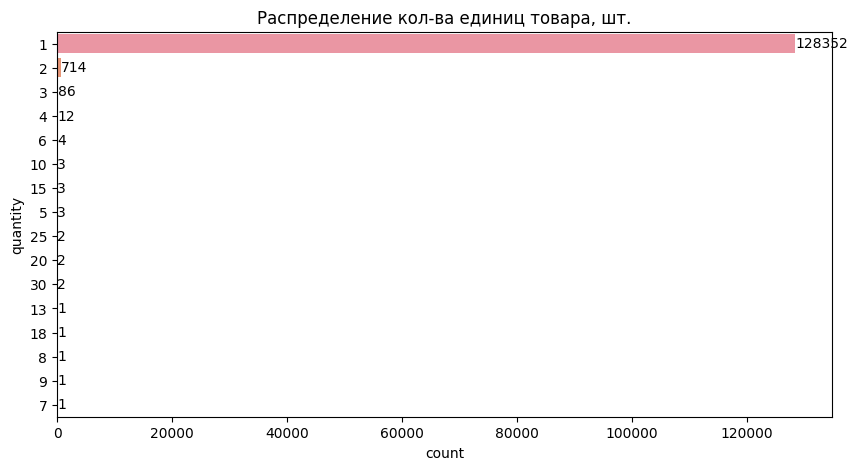

In [268]:
count_graph(df_purchases, 'quantity', 'Распределение кол-ва единиц товара, шт.', 10, 5)

count    129188.000000
mean       1264.532766
std        1375.016339
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64

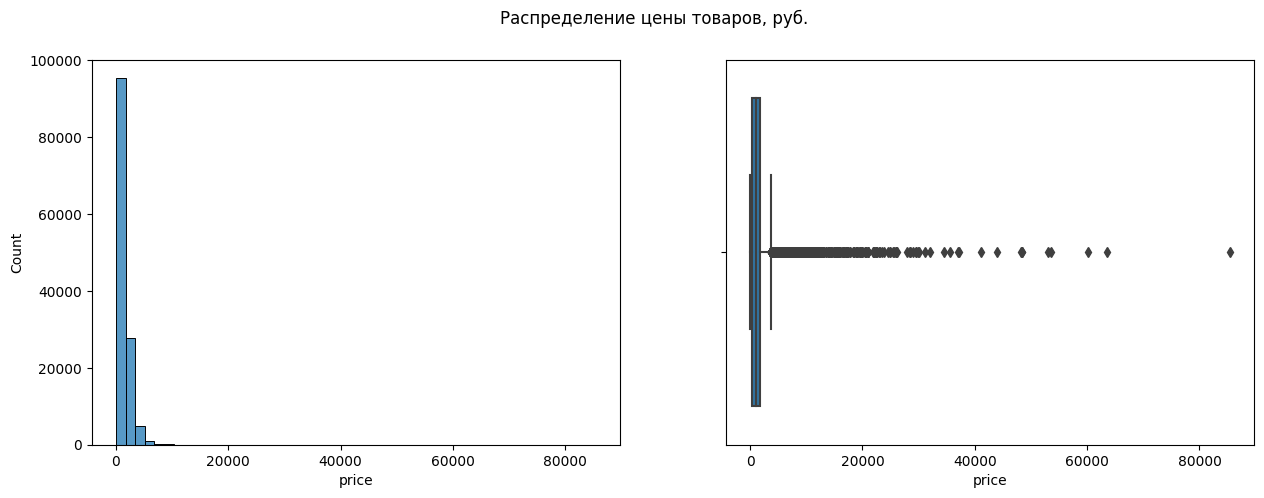

In [269]:
num_stat(df_purchases, 'price', 50, 'Распределение цены товаров, руб.')

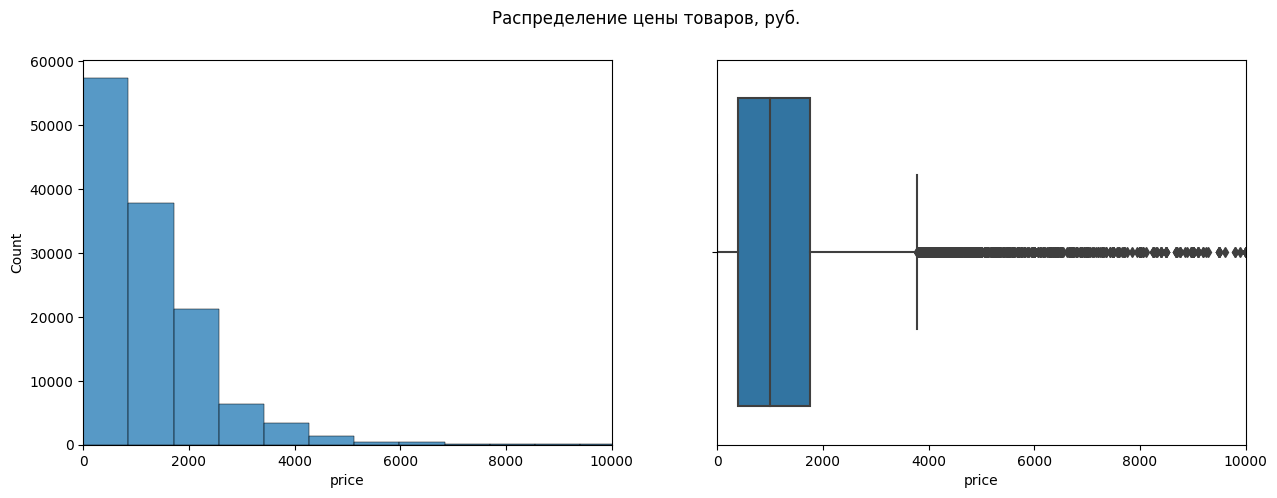

In [270]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(df_purchases['price'], bins=100, ax = axes[0])
axes[0].set_xlim(0,10_000)
sns.boxplot(data=df_purchases, x= 'price')
axes[1].set_xlim(0,10_000)
fig.suptitle('Распределение цены товаров, руб.');

Мы видим, что в диапазоне 0-10_000 большинство значений стоимости попадают в отрезок 0-2500, затем следует спад до 5_000 и затем снова довольно резкое падений количества значений.

In [271]:
df_purchases['date'].value_counts().head(10)

date
2022-11-11    2808
2023-06-10    2356
2023-04-28    1985
2022-06-02    1756
2022-11-15    1656
2022-12-22    1485
2022-11-12    1463
2022-12-21    1448
2022-06-01    1434
2022-06-03    1396
Name: count, dtype: int64

In [272]:
df_purchases['date'].value_counts().tail(10)

date
2023-11-05    5
2022-10-25    5
2022-09-21    4
2023-01-16    4
2023-08-06    4
2023-10-22    4
2023-01-09    3
2022-10-06    2
2023-10-29    2
2023-01-29    2
Name: count, dtype: int64

In [273]:
df_purchases['date'].min()

Timestamp('2022-05-16 00:00:00')

In [274]:
df_purchases['date'].max()

Timestamp('2024-02-16 00:00:00')

Минимальная дата столбца 'date' это 16-05-2022, максимальная: 16-02-2024.

In [275]:
df_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


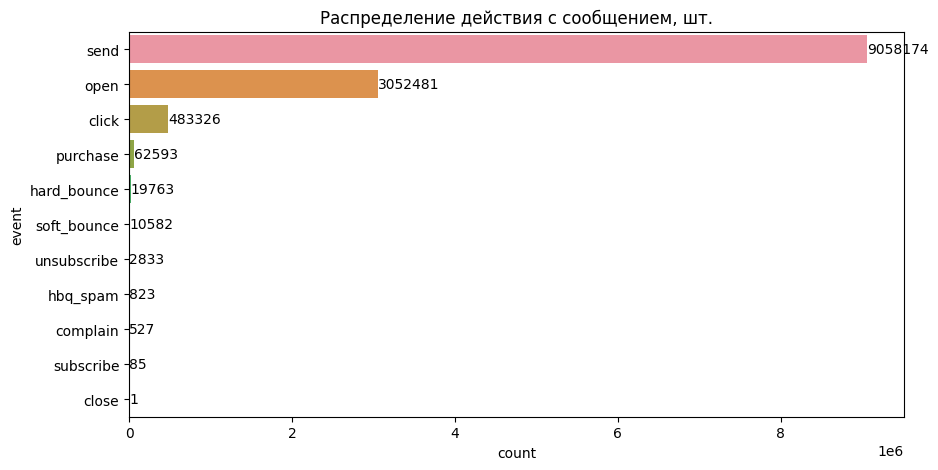

In [276]:
count_graph(df_messages, 'event', 'Распределение действия с сообщением, шт.', 10, 5)

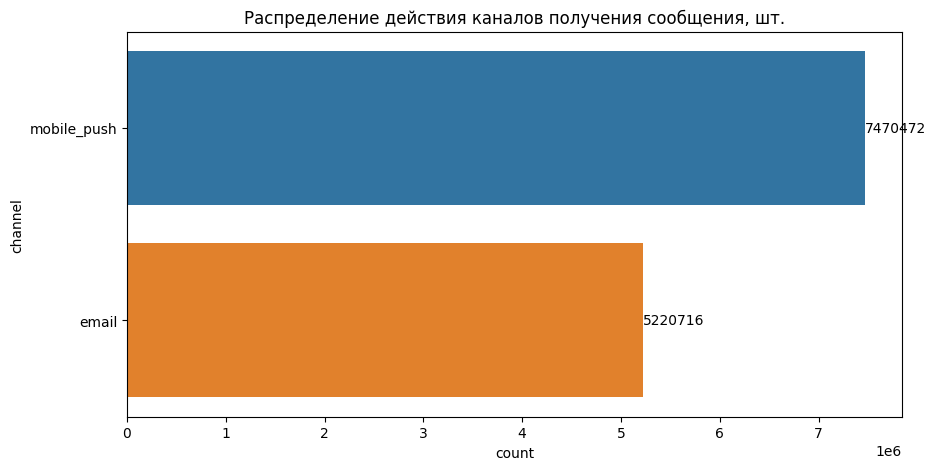

In [277]:
count_graph(df_messages, 'channel', 'Распределение действия каналов получения сообщения, шт.', 10, 5)

Как видно из графика выше, большинство сообщений напрвляется клиентам с помощью мобильных push-уведомлений, однако количество направляемых посредством email сообщений, также значительно

In [278]:
df_messages['date'].value_counts().head(10)

date
2023-06-10    89173
2024-01-26    84242
2023-12-11    82568
2023-12-10    81352
2023-12-26    80116
2023-12-22    77704
2024-01-11    74219
2024-02-09    72652
2023-09-27    72326
2024-01-30    69166
Name: count, dtype: int64

In [279]:
df_messages['date'].value_counts().tail(10)

date
2023-01-29    371
2023-06-18    361
2023-02-28    360
2023-05-14    330
2023-02-26    288
2023-01-08    278
2023-04-11    273
2023-01-07    259
2023-05-09    250
2023-07-02    104
Name: count, dtype: int64

In [280]:
df_messages['date'].min()

Timestamp('2022-05-19 00:00:00')

In [281]:
df_messages['date'].max()

Timestamp('2024-02-15 00:00:00')

Минимальная дата столбца 'date' это 19-05-2022, максимальная: 15-02-2024.

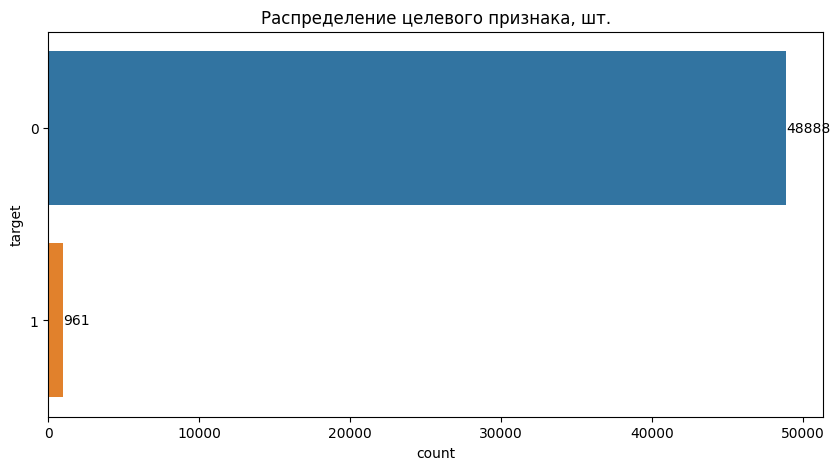

In [282]:
count_graph(df_target, 'target', 'Распределение целевого признака, шт.', 10, 5)

Мы видим что, в значениях целевого признака имеется сильный дисбаланс - количество клиентов имеющих метку 0 (клиент не сделает покупку) преобладает над количеством клиентов с меткой 1 (клиент сделает покупку).

Вывод:
Проведен исследовательский анализ данных датасетов df_purchaeses, df_messages и df_target:

выявлено сильное преобладание значения 1 в столбце 'quantity' датасета df_purchases;  
выявлено различие между минимальной и максимальной датой датасетов df_purchases и df_messages  
выявлен дисбаланс в значениях целевого признака: количество клиентов имеющих метку 0 (клиент не сделает покупку) пребладает над количеством клиентов с меткой 1 (клиент сделает покупку).

**3.Разработка новых признаков**

В датасете df_purchases создаем новый синтетический призак 'quantity_90', который будет отображать количество покупок, сделанных в последние 90 дней.

In [283]:
date_max = df_purchases['date'].max()
date_max

Timestamp('2024-02-16 00:00:00')

In [284]:
date_90 = date_max - pd.Timedelta(days=90)
date_90

Timestamp('2023-11-18 00:00:00')

In [285]:
df_purchases['quantity_90'] = 0

In [286]:
for i in range(len(df_purchases)):
    if df_purchases['date'][i] > date_90:
        df_purchases['quantity_90'][i] =  df_purchases['quantity'][i]

In [287]:
df_purchases['month'] = pd.Series(map(lambda x: x.month, df_purchases['date']))

In [288]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,quantity_90,month
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,5
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,5
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0,5
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0,5
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0,5


In [289]:
df_purchases.tail()

,client_id,quantity,price,category_ids,date,message_id,quantity_90,month
129183,1515915626010221592,1,1499.0,"['4', '28', '260', '1194']",2024-02-16,1515915626010221592-14664-65cf1622434a9,1,2
129184,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,1,2
129185,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,1,2
129186,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,1,2
129187,1515915626010443624,1,999.0,"['4', '28', '62', '656']",2024-02-16,1515915625488468007-14668-65cf5234b1295,1,2


Создадим новый датасет, который будет содержать тех клиентов, у которых есть несколько покупок в разные дни.

In [290]:
purchases_diff_days = df_purchases[['client_id', 'date']]

In [291]:
purchases_diff_days.head()

,client_id,date
0,1515915625468169594,2022-05-16
1,1515915625468169594,2022-05-16
2,1515915625471138230,2022-05-16
3,1515915625471138230,2022-05-16
4,1515915625471138230,2022-05-16


In [292]:
purchases_diff_days.duplicated().sum()

68980

In [293]:
purchases_diff_days = purchases_diff_days.drop_duplicates()

In [294]:
purchases_diff_days.head()

,client_id,date
0,1515915625468169594,2022-05-16
2,1515915625471138230,2022-05-16
5,1515915625471640575,2022-05-16
6,1515915625490211585,2022-05-16
7,1515915625490739153,2022-05-16


In [295]:
purchases_diff_days = purchases_diff_days.groupby('client_id')['date'].count().reset_index()

In [296]:
purchases_diff_days.columns=['client_id', 'purchase_row']

In [297]:
purchases_diff_days = purchases_diff_days[purchases_diff_days['purchase_row'] > 1]

In [298]:
purchases_diff_days.head()

,client_id,purchase_row
4,1515915625468061170,3
8,1515915625468061994,2
9,1515915625468062158,2
15,1515915625468062659,2
19,1515915625468063026,3


In [299]:
df_purchases['category_ids_'] = df_purchases['category_ids'].apply(ast.literal_eval)

In [300]:
df_purchases[['cat1', 'cat2', 'cat3', 'cat4', 'cat5']] = pd.DataFrame(
    df_purchases['category_ids_'].apply(lambda x: (x + ['0'] * 5)[:5]).to_list(), 
    index=df_purchases.index
)

In [301]:
df_purchases[['cat1', 'cat2', 'cat3', 'cat4', 'cat5']].isna().sum()

cat1    622
cat2      0
cat3      0
cat4      0
cat5      0
dtype: int64

In [302]:
df_purchases['cat1'] = df_purchases['cat1'].fillna('0')

Проверим что пропуски удалены, а также посмотрим какой тип данных содержат новые признаки.

In [303]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129188 entries, 0 to 129187
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      129188 non-null  int64         
 1   quantity       129188 non-null  int64         
 2   price          129188 non-null  float64       
 3   category_ids   129188 non-null  object        
 4   date           129188 non-null  datetime64[ns]
 5   message_id     129188 non-null  object        
 6   quantity_90    129188 non-null  int64         
 7   month          129188 non-null  int64         
 8   category_ids_  129188 non-null  object        
 9   cat1           129188 non-null  object        
 10  cat2           129188 non-null  object        
 11  cat3           129188 non-null  object        
 12  cat4           129188 non-null  object        
 13  cat5           129188 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(8

In [304]:
df_purchases[['cat1', 'cat2', 'cat3', 'cat4', 'cat5']] = df_purchases[['cat1', 'cat2', 'cat3', 'cat4', 'cat5']].astype('int')

In [305]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129188 entries, 0 to 129187
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      129188 non-null  int64         
 1   quantity       129188 non-null  int64         
 2   price          129188 non-null  float64       
 3   category_ids   129188 non-null  object        
 4   date           129188 non-null  datetime64[ns]
 5   message_id     129188 non-null  object        
 6   quantity_90    129188 non-null  int64         
 7   month          129188 non-null  int64         
 8   category_ids_  129188 non-null  object        
 9   cat1           129188 non-null  int64         
 10  cat2           129188 non-null  int64         
 11  cat3           129188 non-null  int64         
 12  cat4           129188 non-null  int64         
 13  cat5           129188 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(9), object(3

Создадим новый признак 'revenue' - выручка, который является произведением значений столбцов 'price' и 'quantity'

In [306]:
df_purchases['revenue'] = df_purchases['price'] * df_purchases['quantity']

In [307]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,quantity_90,month,category_ids_,cat1,cat2,cat3,cat4,cat5,revenue
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,5,"[4, 28, 57, 431]",4,28,57,431,0,1999.0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,5,"[4, 28, 57, 431]",4,28,57,431,0,2499.0
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0,5,"[4, 28, 57, 431]",4,28,57,431,0,6499.0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0,5,"[4, 28, 244, 432]",4,28,244,432,0,4999.0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0,5,"[4, 28, 49, 413]",4,28,49,413,0,4999.0


для каждого 'client_id' в датасете имеется несколько строк. для удобства дальнейшего использования датасета выполним группировку по 'client_id'.
Напишем функцию, которая при группировке будет выбирать самое часто встречающееся значение в столбце:

In [308]:
def most_frequent(series):

    return series.mode().iloc[0] if not series.mode().empty else None

In [309]:
df_purchases_group = (
    df_purchases.groupby('client_id')
                .agg({'quantity': 'sum',
                      'price': 'sum',
                      'category_ids': 'nunique',
                      'cat1': most_frequent,
                      'cat2': most_frequent,
                      'cat3': most_frequent,
                      'cat4': most_frequent,
                      'cat5': most_frequent,
                      'date': ['min', 'max'],
                      'quantity_90': 'sum',
                      'revenue': 'mean',
                      'month': most_frequent
                      
                     }).reset_index()
)                  

In [310]:
df_purchases_group.columns = [
    'client_id', 'quantity', 'price', 'category', 'cat1', 'cat2', 
    'cat3', 'cat4', 'cat5', 'date_min', 'date_max', 'quantity_90', 'revenue', 'month'
    ]

In [311]:
df_purchases_group.head()

,client_id,quantity,price,category,cat1,cat2,cat3,cat4,cat5,date_min,date_max,quantity_90,revenue,month
0,1515915625468060902,5,4795.0,5,4,28,176,420,0,2022-05-27,2022-05-27,0,959.000000,5
1,1515915625468061003,6,14135.0,1,4,28,249,615,0,2023-01-04,2023-01-04,0,2355.833333,1
2,1515915625468061099,1,299.0,1,4,28,290,424,0,2022-05-17,2022-05-17,0,299.000000,5
3,1515915625468061100,1,1049.0,1,4,27,1828,5717,0,2024-02-10,2024-02-10,1,1049.000000,2
4,1515915625468061170,8,14102.0,4,4,28,260,420,0,2023-03-26,2023-06-17,0,1762.750000,3


In [312]:
df_purchases_group.shape[0]

49849

Выполним объединение датасета df_purchases_group с ранее созданным датасетом purchases_diff_days, содержащим информацию, о количестве дней, в которые клиент совершал покупки

In [313]:
df_purchases_group = df_purchases_group.merge(purchases_diff_days, on = 'client_id', how='left')

In [314]:
df_purchases_group['purchase_row'] = df_purchases_group['purchase_row'].fillna(0)

Переведем даты в формат единого числа

In [315]:
df_purchases_group['date_min'] = (
                             df_purchases_group['date_min']
                                .astype('str')
                                .str.replace('-', '')
                                .astype('int')
)

In [316]:
df_purchases_group['date_max'] = (
                             df_purchases_group['date_min']
                                .astype('str')
                                .str.replace('-', '')
                                .astype('int')
)

In [317]:
df_purchases_group['date_max'].max()

20240216

Создадим новый признак 'difference_date' - разница между самой поздней покупкой в датасете и самой поздней покупкой у конкретного клиента:

In [318]:
df_purchases_group['difference_date'] = df_purchases_group['date_max'].max() - df_purchases_group['date_max']

In [319]:
df_purchases_group.head()

,client_id,quantity,price,category,cat1,cat2,cat3,cat4,cat5,date_min,date_max,quantity_90,revenue,month,purchase_row,difference_date
0,1515915625468060902,5,4795.0,5,4,28,176,420,0,20220527,20220527,0,959.000000,5,0.0,19689
1,1515915625468061003,6,14135.0,1,4,28,249,615,0,20230104,20230104,0,2355.833333,1,0.0,10112
2,1515915625468061099,1,299.0,1,4,28,290,424,0,20220517,20220517,0,299.000000,5,0.0,19699
3,1515915625468061100,1,1049.0,1,4,27,1828,5717,0,20240210,20240210,1,1049.000000,2,0.0,6
4,1515915625468061170,8,14102.0,4,4,28,260,420,0,20230326,20230326,0,1762.750000,3,3.0,9890


 выполним группировку по 'client_id' для датасета df_messages:

In [320]:
df_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [321]:
df_messages_group = (
    df_messages.groupby('client_id')
                .agg({'bulk_campaign_id': 'nunique',
                      'message_id': 'nunique'
                     }).reset_index()
)                  

In [322]:
df_messages_group.head()

,client_id,bulk_campaign_id,message_id
0,1515915625468060902,127,127
1,1515915625468061003,154,154
2,1515915625468061099,215,215
3,1515915625468061100,265,268
4,1515915625468061170,240,243


Объединим датасеты df-purchases_group и df_messages_group в датасет df_group:

In [323]:
df_group = df_purchases_group.merge(df_messages_group, on = 'client_id', how='left')

In [324]:
df_group.head()

,client_id,quantity,price,category,cat1,cat2,cat3,cat4,cat5,date_min,date_max,quantity_90,revenue,month,purchase_row,difference_date,bulk_campaign_id,message_id
0,1515915625468060902,5,4795.0,5,4,28,176,420,0,20220527,20220527,0,959.000000,5,0.0,19689,127.0,127.0
1,1515915625468061003,6,14135.0,1,4,28,249,615,0,20230104,20230104,0,2355.833333,1,0.0,10112,154.0,154.0
2,1515915625468061099,1,299.0,1,4,28,290,424,0,20220517,20220517,0,299.000000,5,0.0,19699,215.0,215.0
3,1515915625468061100,1,1049.0,1,4,27,1828,5717,0,20240210,20240210,1,1049.000000,2,0.0,6,265.0,268.0
4,1515915625468061170,8,14102.0,4,4,28,260,420,0,20230326,20230326,0,1762.750000,3,3.0,9890,240.0,243.0


In [325]:
df_group.shape[0]

49849

Выведем количество всех возможных значений столбца 'event' в отдельных столбцах и сгруппируем их по значению 'client_id'

In [326]:
events = (pd.get_dummies(df_messages[['client_id', 'event']], 
                                 columns=['event']))

In [327]:
events.head()

,client_id,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe
0,1515915625626736623,False,False,False,False,False,True,False,False,False,False,False
1,1515915625490086521,False,False,False,False,False,True,False,False,False,False,False
2,1515915625553578558,False,False,False,False,False,True,False,False,False,False,False
3,1515915625553578558,True,False,False,False,False,False,False,False,False,False,False
4,1515915625471518311,False,False,False,False,False,True,False,False,False,False,False


In [328]:
events = events.groupby('client_id').sum().reset_index()

In [329]:
events.head()

,client_id,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1
1,1515915625468061003,5,0,0,0,0,5,1,154,0,0,0
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0
3,1515915625468061100,1,0,0,1,0,157,1,267,1,0,0
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0


Выведем количество всех возможных значений столбца 'channels' в отдельных столбцах и сгруппируем их по значению 'client_id'

In [330]:
channels = (pd.get_dummies(df_messages[['client_id', 'channel']], 
                                   columns=['channel']))

In [331]:
channels.head()

,client_id,channel_email,channel_mobile_push
0,1515915625626736623,True,False
1,1515915625490086521,True,False
2,1515915625553578558,True,False
3,1515915625553578558,True,False
4,1515915625471518311,True,False


In [332]:
channels = channels.groupby('client_id').sum().reset_index()

In [333]:
channels.head()

,client_id,channel_email,channel_mobile_push
0,1515915625468060902,177,0
1,1515915625468061003,165,0
2,1515915625468061099,182,94
3,1515915625468061100,0,428
4,1515915625468061170,202,91


Соеденим полученные датафреймы enents и channels с ранее сформированным датасетом df_group

In [334]:
df_group = df_group.merge(events, on = 'client_id', how='left')

In [335]:
df_group = df_group.merge(channels, on = 'client_id', how='left')

In [336]:
df_group.head()

,client_id,quantity,price,category,cat1,cat2,cat3,cat4,cat5,date_min,...,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push
0,1515915625468060902,5,4795.0,5,4,28,176,420,0,20220527,...,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,177.0,0.0
1,1515915625468061003,6,14135.0,1,4,28,249,615,0,20230104,...,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,165.0,0.0
2,1515915625468061099,1,299.0,1,4,28,290,424,0,20220517,...,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0,182.0,94.0
3,1515915625468061100,1,1049.0,1,4,27,1828,5717,0,20240210,...,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0,0.0,428.0
4,1515915625468061170,8,14102.0,4,4,28,260,420,0,20230326,...,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0,202.0,91.0


In [337]:
df_group.shape[0]

49849

In [338]:
df_target.shape[0]

49849

In [339]:
df_group = df_group.merge(df_target, on = 'client_id')

In [340]:
df_group.shape[0]

49849

In [341]:
df_group.isna().sum()

client_id                 0
quantity                  0
price                     0
category                  0
cat1                      0
cat2                      0
cat3                      0
cat4                      0
cat5                      0
date_min                  0
date_max                  0
quantity_90               0
revenue                   0
month                     0
purchase_row              0
difference_date           0
bulk_campaign_id       7867
message_id             7867
event_click            7867
event_close            7867
event_complain         7867
event_hard_bounce      7867
event_hbq_spam         7867
event_open             7867
event_purchase         7867
event_send             7867
event_soft_bounce      7867
event_subscribe        7867
event_unsubscribe      7867
channel_email          7867
channel_mobile_push    7867
target                    0
dtype: int64

пропуски обусловлены отстутсвием некоторых значений client_id из датасета df_purchases в датасете df_messages,заменим их на значение 0.

In [342]:
df_group = df_group.fillna(0)

In [343]:
df_group.isna().sum()

client_id              0
quantity               0
price                  0
category               0
cat1                   0
cat2                   0
cat3                   0
cat4                   0
cat5                   0
date_min               0
date_max               0
quantity_90            0
revenue                0
month                  0
purchase_row           0
difference_date        0
bulk_campaign_id       0
message_id             0
event_click            0
event_close            0
event_complain         0
event_hard_bounce      0
event_hbq_spam         0
event_open             0
event_purchase         0
event_send             0
event_soft_bounce      0
event_subscribe        0
event_unsubscribe      0
channel_email          0
channel_mobile_push    0
target                 0
dtype: int64

In [344]:
df_group.duplicated().sum()

0

Вывод:  
Сформированы следующие синтетические признаки:  

'quantity_90' - количество товаров, приобретенных в последние 90 дней;  
'month' - номер месяца покупки;  
'revenue' - выручка полусченная от клиента;  
'cat1', 'cat2', 'cat3', 'cat4', 'cat5' - уровни категорий по столбцу 'category_ids';  
'purchase_row' - количество дней, в которые были совершены покупки  
'date_min' - минимальная дата покупки;  
'date_max' - максимальная дата покупки;  
'difference_date' - разница между самой поздней покупкой в датасете и самой поздней покупкой у конкретного клиента;  
'event_X' - где X это все уникальные значения столбца event;  
'channel_X' - где X это все уникальные значения столбца channel.  

**4. Проверка на мультиколлинеарность**

Проверим на мультиколлинеарность входящие признаки датасета, путем составляения матрицы корреляции. 

In [345]:
corr_spearman = df_group.corr(method='spearman')

In [346]:
corr_spearman

,client_id,quantity,price,category,cat1,cat2,cat3,cat4,cat5,date_min,...,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,target
client_id,1.000000,-0.024171,-0.030234,-0.027838,0.019367,0.029000,0.049033,0.085042,0.006803,0.272124,...,-0.051628,-0.295571,-0.219638,-0.318965,-0.038943,-0.005329,-0.046756,-0.473496,-0.046920,-0.006466
quantity,-0.024171,1.000000,0.527323,0.856474,0.070049,0.029475,-0.034660,-0.077443,-0.031496,0.024523,...,-0.008968,0.029709,0.233978,0.033498,0.001315,0.003709,-0.027178,0.009174,0.043421,0.062288
price,-0.030234,0.527323,1.000000,0.456277,-0.131279,-0.118339,-0.197237,-0.082975,-0.018749,-0.093634,...,0.004135,0.044300,0.189350,0.016891,0.007124,0.001860,0.000214,0.065981,-0.006167,0.017075
category,-0.027838,0.856474,0.456277,1.000000,0.031577,-0.015190,-0.091739,-0.142150,-0.037022,-0.032697,...,-0.010555,0.044233,0.245457,0.049944,0.002200,0.005636,-0.023572,0.027202,0.053018,0.062637
cat1,0.019367,0.070049,-0.131279,0.031577,1.000000,0.904960,0.560178,0.328411,-0.080983,0.070167,...,-0.002478,-0.052695,0.007142,0.078238,0.003818,-0.005194,-0.019201,-0.063475,0.104320,0.007593
cat2,0.029000,0.029475,-0.118339,-0.015190,0.904960,1.000000,0.609319,0.357136,-0.088721,0.087618,...,-0.000609,-0.055791,-0.010847,0.062271,0.002568,-0.002829,-0.011279,-0.067260,0.091661,0.004616
cat3,0.049033,-0.034660,-0.197237,-0.091739,0.560178,0.609319,1.000000,0.481885,0.041733,0.106229,...,0.007791,-0.049081,-0.033624,0.035727,0.001022,-0.001488,-0.011365,-0.067170,0.068777,-0.004853
cat4,0.085042,-0.077443,-0.082975,-0.142150,0.328411,0.357136,0.481885,1.000000,-0.082409,0.159780,...,-0.000583,-0.052817,-0.060365,-0.012582,-0.000532,-0.006804,-0.019802,-0.099405,0.044752,0.005574
cat5,0.006803,-0.031496,-0.018749,-0.037022,-0.080983,-0.088721,0.041733,-0.082409,1.000000,0.013152,...,0.006678,-0.006724,-0.014053,-0.010394,-0.000281,-0.001890,-0.006586,-0.008680,-0.007631,-0.007169
date_min,0.272124,0.024523,-0.093634,-0.032697,0.070167,0.087618,0.106229,0.159780,0.013152,1.000000,...,-0.042813,-0.191898,-0.218085,-0.182087,-0.020174,-0.007273,-0.054032,-0.292105,-0.016276,0.029059


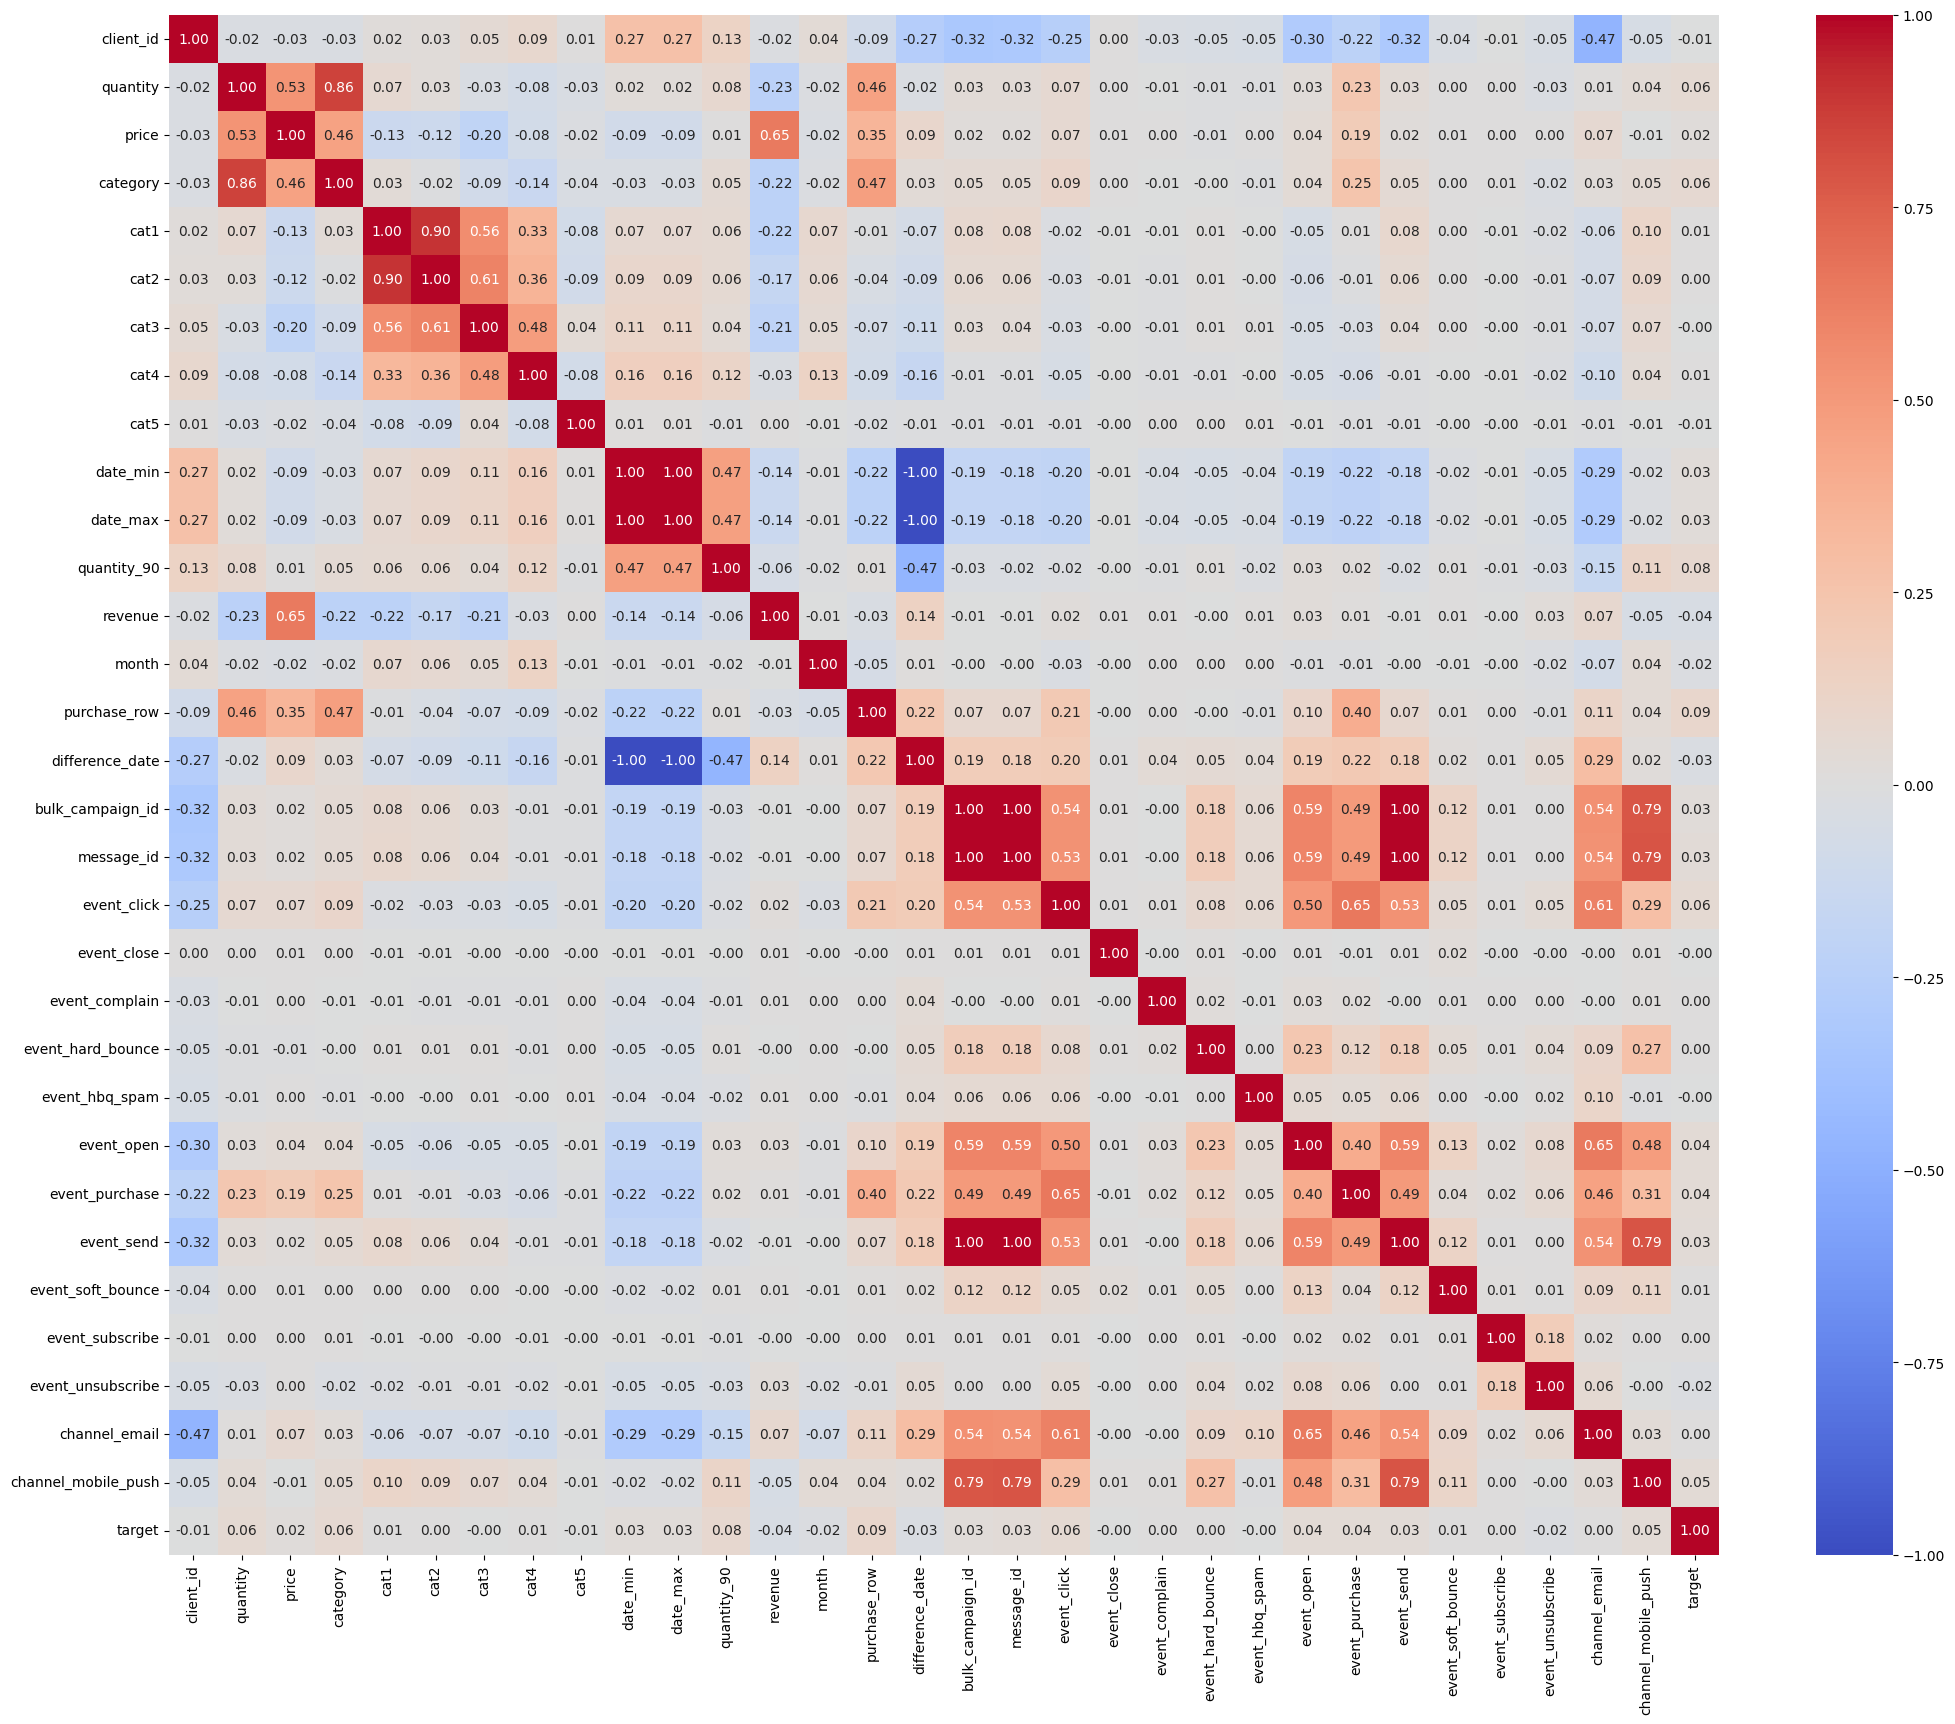

In [347]:
ax, fig = plt.subplots(figsize=(25,20))
sns.heatmap(corr_spearman, annot=corr_spearman, cmap='coolwarm', fmt='.2f',  annot_kws={"size":10});

In [348]:
df_group = df_group.drop([
   'date_min', 'bulk_campaign_id', 'channel_mobile_push',
   'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'event_close', 'event_subscribe'
],  axis=1)

In [349]:
corr_spearman = df_group.corr(method='spearman')

In [350]:
corr_spearman

,client_id,quantity,price,category,date_max,quantity_90,revenue,month,purchase_row,difference_date,...,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_unsubscribe,channel_email,target
client_id,1.000000,-0.024171,-0.030234,-0.027838,0.272124,0.128798,-0.015850,0.041095,-0.090313,-0.272124,...,-0.031269,-0.045648,-0.051628,-0.295571,-0.219638,-0.318965,-0.038943,-0.046756,-0.473496,-0.006466
quantity,-0.024171,1.000000,0.527323,0.856474,0.024523,0.075380,-0.229916,-0.020808,0.459184,-0.024523,...,-0.006587,-0.008528,-0.008968,0.029709,0.233978,0.033498,0.001315,-0.027178,0.009174,0.062288
price,-0.030234,0.527323,1.000000,0.456277,-0.093634,0.006888,0.646881,-0.023593,0.345369,0.093634,...,0.000371,-0.012200,0.004135,0.044300,0.189350,0.016891,0.007124,0.000214,0.065981,0.017075
category,-0.027838,0.856474,0.456277,1.000000,-0.032697,0.047754,-0.222123,-0.017576,0.473271,0.032697,...,-0.007274,-0.001687,-0.010555,0.044233,0.245457,0.049944,0.002200,-0.023572,0.027202,0.062637
date_max,0.272124,0.024523,-0.093634,-0.032697,1.000000,0.467444,-0.135897,-0.009876,-0.219210,-1.000000,...,-0.043916,-0.047720,-0.042813,-0.191898,-0.218085,-0.182087,-0.020174,-0.054032,-0.292105,0.029059
quantity_90,0.128798,0.075380,0.006888,0.047754,0.467444,1.000000,-0.056035,-0.015005,0.012297,-0.467444,...,-0.014209,0.010052,-0.017347,0.025245,0.018698,-0.024577,0.006681,-0.034976,-0.154965,0.076326
revenue,-0.015850,-0.229916,0.646881,-0.222123,-0.135897,-0.056035,1.000000,-0.005402,-0.032758,0.135897,...,0.006257,-0.004848,0.012578,0.030769,0.009643,-0.007472,0.005629,0.025878,0.072863,-0.042780
month,0.041095,-0.020808,-0.023593,-0.017576,-0.009876,-0.015005,-0.005402,1.000000,-0.054849,0.009876,...,0.000053,0.003518,0.003529,-0.012973,-0.008566,-0.003719,-0.005675,-0.017288,-0.074046,-0.021371
purchase_row,-0.090313,0.459184,0.345369,0.473271,-0.219210,0.012297,-0.032758,-0.054849,1.000000,0.219210,...,0.001843,-0.003079,-0.009384,0.100873,0.396310,0.072249,0.008548,-0.014551,0.111993,0.088912
difference_date,-0.272124,-0.024523,0.093634,0.032697,-1.000000,-0.467444,0.135897,0.009876,0.219210,1.000000,...,0.043916,0.047720,0.042813,0.191898,0.218085,0.182087,0.020174,0.054032,0.292105,-0.029059


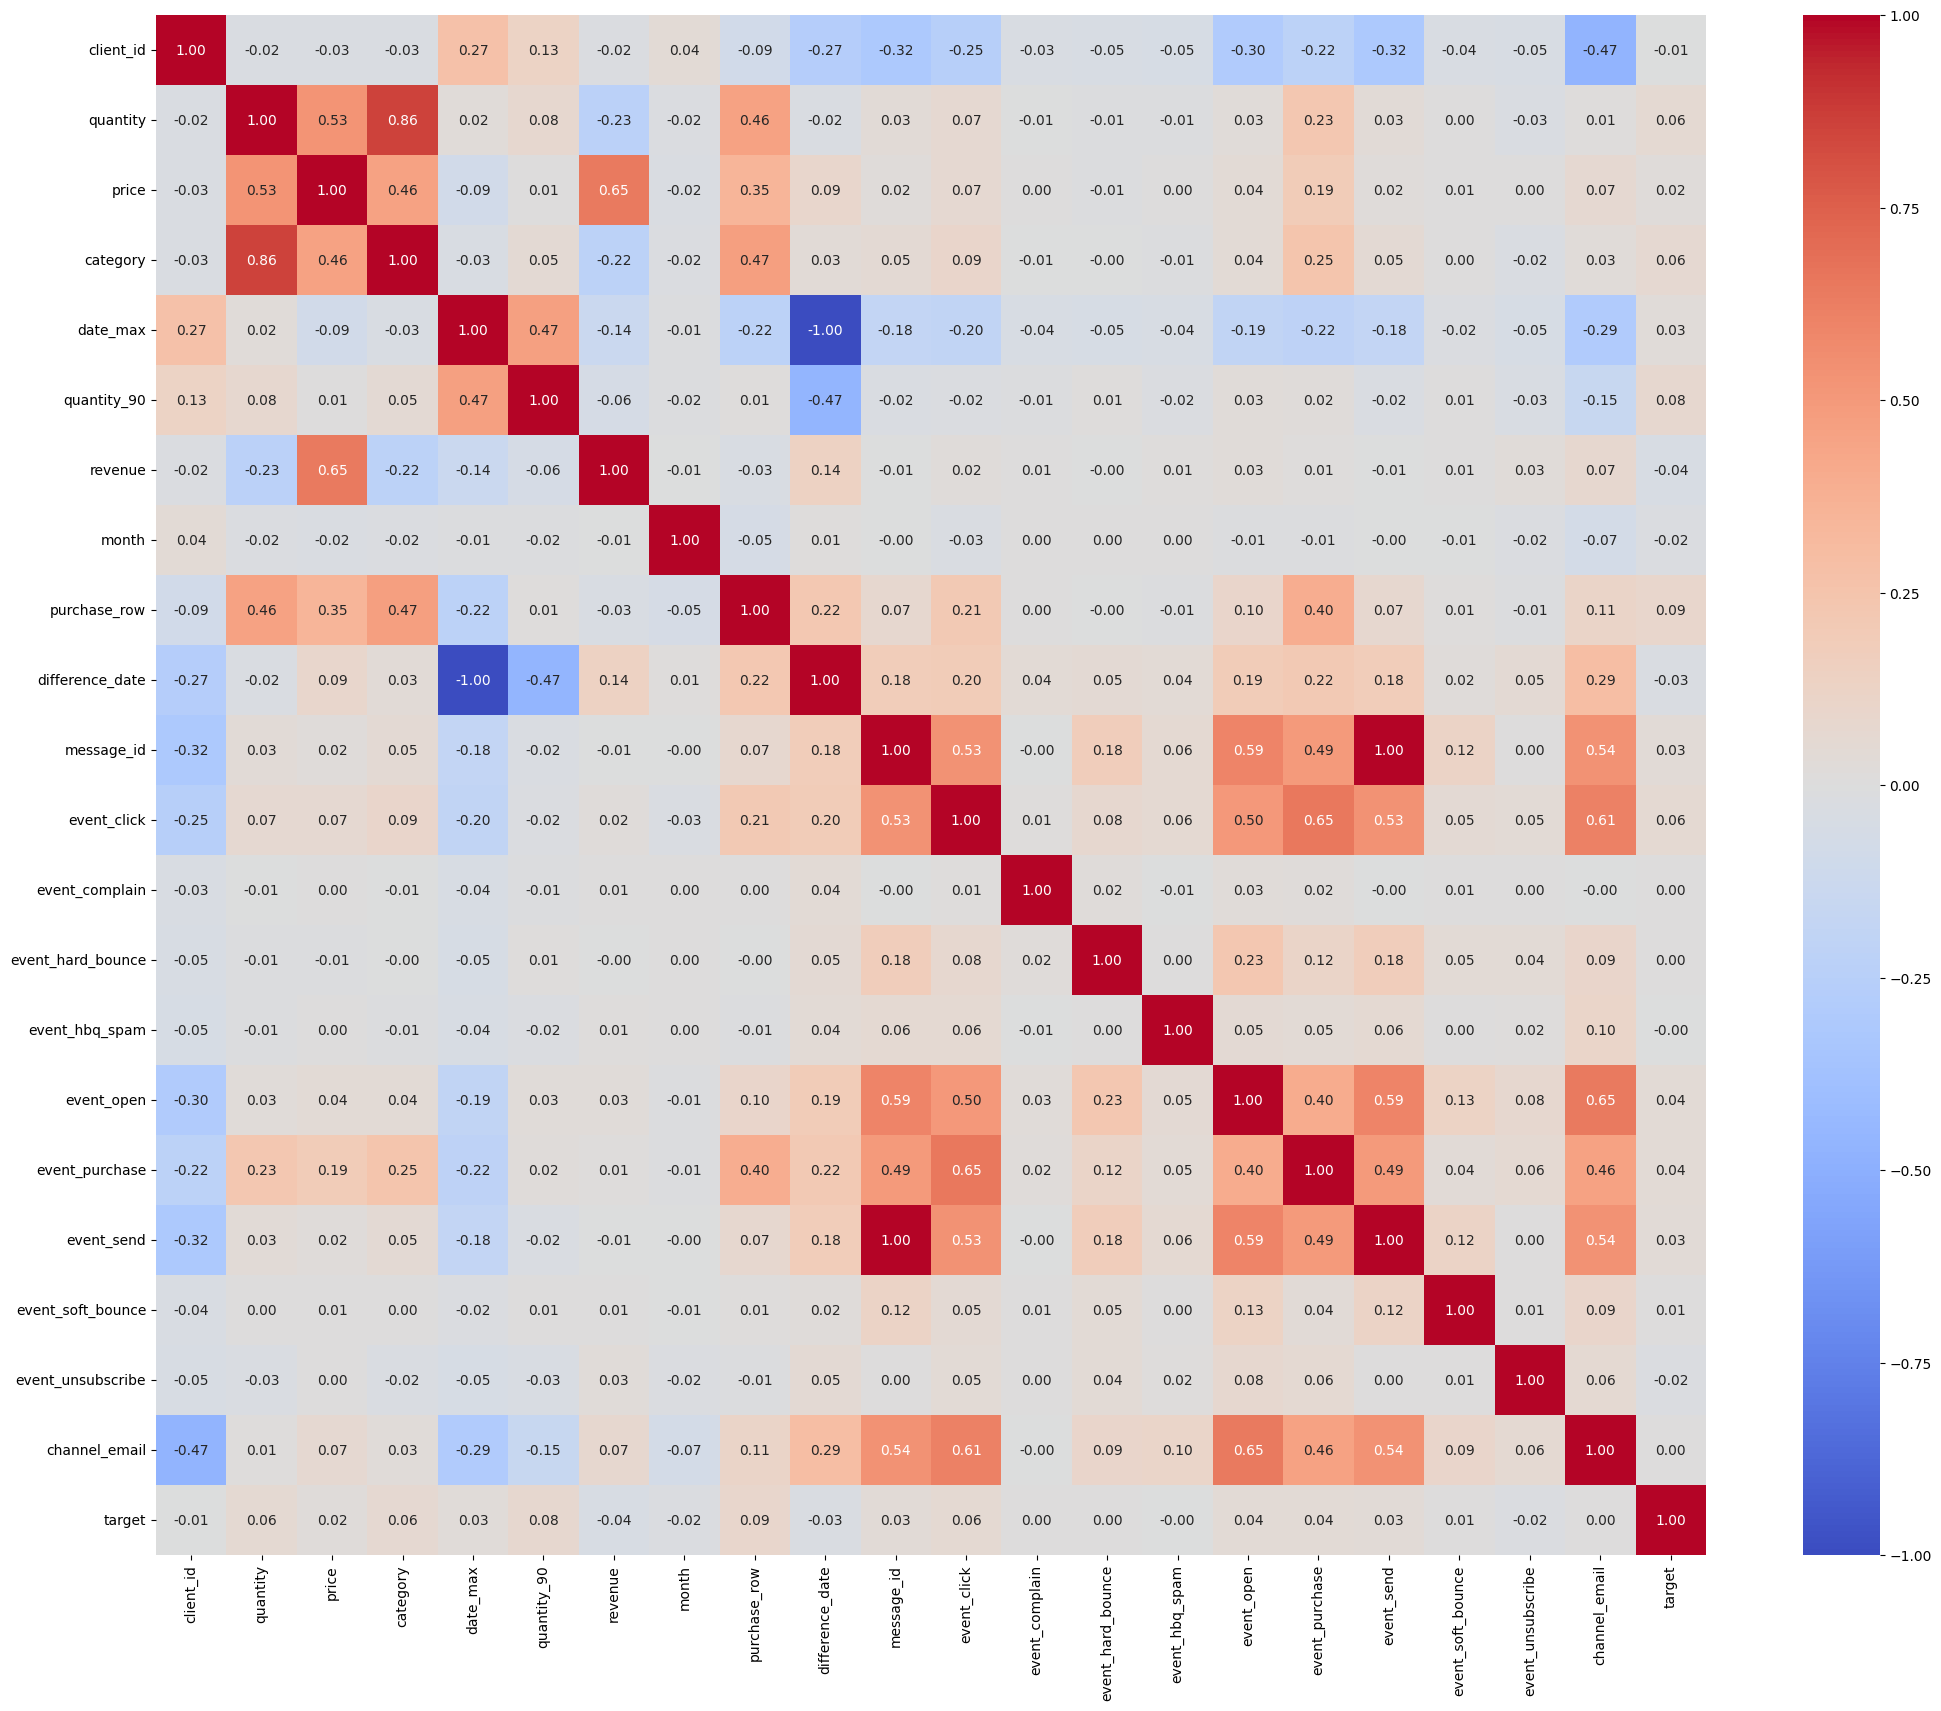

In [351]:
ax, fig = plt.subplots(figsize=(25,20))
sns.heatmap(corr_spearman, annot=corr_spearman, cmap='coolwarm', fmt='.2f',  annot_kws={"size":10});

Вывод: Выполнена проверка на мультиколлинеарность путем составления матрицы корреляции. Удалены сильно коррелирующие между собой входящие признаки.

**5. Выбор и обучение модели**

Удалим из итогового датасета целевой признак и неинформативный идентификационный столбец 'client_id'

In [352]:
X = df_group.drop(['target', 'client_id'],  axis=1)
y = df_group['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify=y
 )


num_columns = [
    'quantity', 'price', 'category', 'date_max',  'quantity_90', 'revenue', 'month', 'message_id',  'event_click',
    'event_complain', 'event_hard_bounce', 'event_hbq_spam', 'event_open', 'event_purchase', 'event_send',
    'event_soft_bounce', 'event_unsubscribe', 'channel_email', 'difference_date', 'purchase_row'   
]


             

data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [353]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE
        )],
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    
     {
        'models': [RandomForestClassifier(
         random_state=RANDOM_STATE
        )],
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),  'passthrough']
    },

    {
        'models': [LGBMClassifier()],
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),  'passthrough']
    },    
    
    {
        'models': [CatBoostClassifier(silent=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),  'passthrough']
    }  
]


grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print('Лучшая метрика на кросс-валидационной выборке:', grid_search.best_score_)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['quantity', 'price',
                                                   'category', 'date_max',
                                                   'quantity_90', 'revenue',
                                                   'month', 'message_id',
                                                   'event_click',
                                                   'event_complain',
                                                   'event_hard_bounce',
                                                   'event_hbq_spam',
                                                   'event_open',
                                                   'event_purchase',
                                                   'event_send',
                             

In [354]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__class_weight,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.214800,0.042460,0.016478,0.002544,"LogisticRegression(class_weight='balanced', ra...",balanced,StandardScaler(),{'models': LogisticRegression(class_weight='ba...,0.697497,0.729371,0.760995,0.730376,0.745153,0.732678,0.021031,2
1,0.482002,0.014982,0.016727,0.000326,"LogisticRegression(class_weight='balanced', ra...",balanced,MinMaxScaler(),{'models': LogisticRegression(class_weight='ba...,0.698782,0.725506,0.755112,0.730641,0.747695,0.731547,0.019631,3
2,0.400575,0.081099,0.016383,0.000835,"LogisticRegression(class_weight='balanced', ra...",balanced,RobustScaler(),{'models': LogisticRegression(class_weight='ba...,0.697557,0.729325,0.760968,0.730354,0.745196,0.732680,0.021010,1
3,0.269981,0.059488,0.013225,0.000325,"LogisticRegression(class_weight='balanced', ra...",balanced,passthrough,{'models': LogisticRegression(class_weight='ba...,0.613987,0.659036,0.586567,0.604544,0.694327,0.631692,0.039389,27
4,0.196631,0.021213,0.018715,0.001846,"LogisticRegression(class_weight='balanced', ra...",None,StandardScaler(),{'models': LogisticRegression(class_weight='ba...,0.687400,0.725613,0.754333,0.729820,0.745964,0.728626,0.023115,4
5,0.275121,0.027157,0.016708,0.000514,"LogisticRegression(class_weight='balanced', ra...",None,MinMaxScaler(),{'models': LogisticRegression(class_weight='ba...,0.695543,0.712881,0.734866,0.715901,0.738159,0.719470,0.015588,6
6,0.306193,0.014160,0.018038,0.000821,"LogisticRegression(class_weight='balanced', ra...",None,RobustScaler(),{'models': LogisticRegression(class_weight='ba...,0.687294,0.725579,0.754209,0.729550,0.746223,0.728571,0.023163,5
7,0.128991,0.029743,0.013398,0.000870,"LogisticRegression(class_weight='balanced', ra...",None,passthrough,{'models': LogisticRegression(class_weight='ba...,0.461543,0.422577,0.565745,0.572749,0.646168,0.533756,0.080939,28
8,7.668811,0.354756,0.162063,0.002196,RandomForestClassifier(random_state=42),balanced,StandardScaler(),{'models': RandomForestClassifier(random_state...,0.676222,0.641634,0.669518,0.672989,0.687116,0.669496,0.015128,26
9,7.016618,0.120768,0.161652,0.002448,RandomForestClassifier(random_state=42),balanced,MinMaxScaler(),{'models': RandomForestClassifier(random_state...,0.681111,0.645454,0.670734,0.671963,0.688043,0.671461,0.014459,24


По результатам работы пайплайна выше, определена лучшая модель - LogisticRegression. Уточним гиперпараметры этой модели для улучшения метрики на кросс-валидации

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE
        )],
        'models__C': [.1, 1, 2, 3, 5, 10, 12],
        'models__penalty': ['l1', 'l2', 'elasticnet'],
        'models__class_weight': ['balanced', None],
        'models__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }

]


grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print('Лучшая метрика на кросс-валидационной выборке:', grid_search.best_score_)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [ ]:
predict =  grid_search.best_estimator_.predict(X_test)
probas = grid_search.best_estimator_.predict_proba(X_test)

In [ ]:
# считаем и выводим accuracy
acc = accuracy_score(y_test, predict)
print('Accuracy =', round(acc,3))

# считаем и выводим ROC-AUC
roc = roc_auc_score(y_test, probas[:,1])
print('ROC-AUC =', round(roc,3))

# считаем и выводим F1-меру
f1 = f1_score(y_test, predict, pos_label=1)
print('F1-score =', round(f1,3)) 

# считаем и выводим recall
recall = recall_score(y_test, predict, pos_label=1)
print('recall =', round(recall,3)) 

# считаем и выводим precision
precision = precision_score(y_test, predict, pos_label=1)
print('precision =', round(precision,3)) 


# построим матрицу ошибок 
cm = confusion_matrix(y_test, predict)
cmp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
cmp.plot();

Вывод: 
По результату обучения на тренировочной выборке, определены следующие параметры, формирующие наилучшие результаты на кросс-валидационной выборке:

масштабирование: RobustScaler()

модель: LogisticRegression(C=2, class_weight='balanced', penalty='l1', random_state=42, solver='liblinear'))])

метрика ROC- AUC на кросс-валидационной выборке: 0.733

метрики на тестовой выборке:

Accuracy = 0.74  
ROC-AUC = 0.745  
F1-score = 0.086  
recall = 0.638  
precision = 0.046  

Также по матрице ошибок можно заметить, что среди 240 потенциальных покупателей, модель верно определила 153 клиента, что составило 64%, однако также модель ошибочно определила 3159 клиентов, которые не будут делать покупки, как потенциальных покупателей.

**6. Анализ важности признаков лучшей модели**

Применим лучшую модель, полученную по итогам работы пайплайна:

In [ ]:
model = grid_search.best_estimator_

In [ ]:
model

In [ ]:
model['preprocessor'].fit(X_train)

In [ ]:
X_train_preprocessed = model['preprocessor'].transform(X_train)

In [ ]:
column_names = model['preprocessor'].get_feature_names_out()

In [ ]:
data = pd.DataFrame(X_train_preprocessed, columns=column_names)

In [ ]:
data.head()

In [ ]:
masker = shap.maskers.Independent(data = data)

In [ ]:
explainer = shap.LinearExplainer(model['models'], masker=masker)
shap_values = explainer(data)

In [ ]:
shap.plots.bar(shap_values, max_display=17) 

Вывод: 
По результатам анализа полученных графиков, можно прийти к следующим выводам: 

менее на прогноз целевого признака влияют следующие входные параметры: 'revenue', 'date_max', 'event_send', 'event_unsubscribe';  
более всего на прогноз целевого признака влияют следующие входные параметры: 'channel_email', 'event_click', 'event_open', 'purchase_row', 'difference_date'.  

Для повышения вероятности совершения покупки клиентом, стоит направлять рекламные рассылки людям, которые совершали покупку в ближайшие и при этом также они совершали одну и более покупок в другие дни до этого.

**7. Общий вывод**

Предварительная обработка:

загружены необходимые для исследования датасеты;  
датасеты проверены на корректность вывода;  
датасет проверен на наличие пропусков в данных (пропуски не выявлены);  
данные проверены на наличие явных дубликатов, выяыленные дубликаты удалены из датасета;  
значения, отображающие даты событий, переведены из строкового формата в формат datetime.  

Исследовательский анализ:

выявлено сильное преобладание значения 1 в столбце 'quantity' датасета df_purchases;  
выявлено различие между минимальной и максимальной датой датасетов df_purchases и df_messages, также 
выявлен дисбаланс в значениях целевого признака: количество клиентов имеющих метку 0 (клиент не сделает покупку) сильно превалирует над количеством клиентов с меткой 1 (клиент сделает покупку). 

Разработали синтетические признаки:

'quantity_90' - количество товаров, приобретенных в последние 90 дней;
'month' - номер месяца покупки;
'revenue' - выручка полусченная от клиента;
'cat1', 'cat2', 'cat3', 'cat4', 'cat5' - уровни категорий по стоkбцу 'category_ids';
'purchase_row' - количество дней, в которые были совершены покупки (если таких дней было более 1)
'date_min' - минимальная дата покупки;
'date_max' - максимальная дата покупки;
'difference_date' - разница между самой поздней покупкой в датасете и самой поздней покупкой у конкретного клиента;
'event_X' - где X это все уникальные значения столбца event;
'channel_X' - где X это все уникальные значения столбца channel.

Выполнена проверка на мультиколлинеарность путем составления матрицы корреляции. Удалены сильно коррелирующие между собой входящие признаки. 

По результату обучения на тренировочной выборке, определены следующие параметры, формирующие наилучшие результаты на кросс-валидационной выборке:

масштабирование: RobustScaler()

модель: LogisticRegression(C=2, class_weight='balanced', penalty='l1', random_state=42, solver='liblinear'))])

метрика ROC- AUC на кросс-валидационной выборке: 0.733

метрики на тестовой выборке:

Accuracy = 0.74
ROC-AUC = 0.745
F1-score = 0.086
recall = 0.638
precision = 0.046

Также матрица ошибок показала, что среди 240 потенциальных покупателей, модель верно определила 153 клиента, что составило 64%, однако также модель ошибочно определила 3159 клиентов, которые не будут делать покупки, как потенциальных покупателей. 

По результатам анализа SHAP графиков, можно прийти к следующим выводам: 

менее на прогноз целевого признака влияют следующие входные параметры: 'revenue', 'date_max', 'event_send', 'event_unsubscribe';  
более всего на прогноз целевого признака влияют следующие входные параметры: 'channel_email', 'event_click', 'event_open', 'purchase_row', 'difference_date'.

Для повышения вероятности совершения покупки клиентом, стоит направлять рекламные рассылки людям, которые совершали покупку в ближайшие и при этом также они совершали одну и более покупок в другие дни до этого.